In [42]:
import glob
import gzip
import pickle
import os
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import pystan
from matplotlib.ticker import MultipleLocator
from scipy.stats import gaussian_kde
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
rcParams['figure.figsize'] = 16, 10
COMMON_SEED = 1234

def check_convergence(fit, also_print=False):
    report = print if also_print else lambda x: None
    
    def all_rhat_small_enough(fit):
        return all(dict(fit.summary())['summary'][:, -1] < 1.1)
    
    def max_treedepth_exceeded(fit, max_depth = 10):
        """Check transitions that ended prematurely due to maximum tree depth limit"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        depths = [x for y in sampler_params for x in y['treedepth__']]
        n = sum(1 for x in depths if x == max_depth)
        if n > 0:
            report('Run again with max_depth set to a larger value to avoid saturation')        
        N = len(depths)
        report(('{} of {} iterations saturated the maximum tree depth of {}'
               + ' ({}%)').format(n, N, max_depth, 100 * n / N))
        return float(n) / N
    
    def e_bfmi_all_low_enough(fit):
        """
        Checks the energy Bayesian fraction of missing information (E-BFMI).
        E-BFMI below 0.2 indicates you may need to reparameterize your model
        """
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        for chain_num, s in enumerate(sampler_params):
            energies = s['energy__']
            numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
            denom = np.var(energies)
            if numer / denom < 0.2:
                report('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
                report('E-BFMI below 0.2 indicates you may need to reparameterize your model')
                return False
        return True

    def fraction_of_transitions_which_ended_with_divergence(fit):
        """Check transitions that ended with a divergence"""
        sampler_params = fit.get_sampler_params(inc_warmup=False)
        divergent = [x for y in sampler_params for x in y['divergent__']]
        n = sum(divergent)
        N = len(divergent)
        report('{} of {} iterations ended with a divergence ({}%)'
              .format(n, N, 100 * n / N))
        if n > 0:
            report('Try running with larger adapt_delta to remove the divergences')
        return n / N
    
    assert all_rhat_small_enough(fit)
    assert max_treedepth_exceeded(fit) < 0.02
    assert e_bfmi_all_low_enough(fit)
    assert fraction_of_transitions_which_ended_with_divergence(fit) <= 5E-3
    report("##### All convergence checks passed successfully. #####")

In [6]:
births_2000s_df = pd.read_csv('US_births_2000-2014_SSA.csv')
births_2000s_df_with_index = births_2000s_df\
    .rename(columns={'date_of_month': 'day'})\
    .set_index(pd.to_datetime(
        births_2000s_df.rename(columns={'date_of_month': 'day'})
        [['year', 'month', 'day']]))\
    .assign(weekday_name=lambda df: df.index.weekday_name)\
    .assign(day_of_year=lambda df: df.index.dayofyear)\
    .assign(week_of_year=lambda df: df.index.weekofyear)
births_2000s_df_with_index.tail()

,year,month,day,day_of_week,births,weekday_name,day_of_year,week_of_year
2014-12-27,2014,12,27,6,8656,Saturday,361,52
2014-12-28,2014,12,28,7,7724,Sunday,362,52
2014-12-29,2014,12,29,1,12811,Monday,363,1
2014-12-30,2014,12,30,2,13634,Tuesday,364,1
2014-12-31,2014,12,31,3,11990,Wednesday,365,1


In [7]:
def weekday_priors_by_year_2000():
    df_2000 = births_2000s_df_with_index[lambda df: df.year == 2000]
    return df_2000.groupby('day_of_week').agg(['mean', 'std']).births

weekday_priors_by_year_2000()

,mean,std
day_of_week,,
1,11514.461538,1036.715902
2,12870.846154,790.289954
3,12762.269231,422.905919
4,12735.461538,813.567006
5,12524.500000,634.105530
6,9049.830189,344.643056
7,8014.433962,310.302366


In [8]:
def get_train_and_test_for_sliding_window(test_date):
    num_data_points_before_first_test_date = datetime(2014, 1, 1) - datetime(2001, 1, 1)
    df = births_2000s_df_with_index[['day_of_week', 'births']]\
        [lambda df: df.index <= test_date + timedelta(days=6)]\
        [lambda df: df.index >= test_date - num_data_points_before_first_test_date]
    return {
        'x_train': df.day_of_week[:-7].values,
        'y_train': df.births[:-7].values,
        'x_test': df.day_of_week[-7:].values,
        'y_test': df.births[-7:].values
    }
        
get_train_and_test_for_sliding_window(datetime(2014, 1, 1))

{'x_test': array([3, 4, 5, 6, 7, 1, 2]),
 'x_train': array([1, 2, 3, ..., 7, 1, 2]),
 'y_test': array([ 8018, 11171, 12317,  8199,  7174, 11400, 12310]),
 'y_train': array([ 7663, 10635, 12449, ...,  7896, 13096, 12525])}

In [9]:
def rmse(prediction_errors):
    return (prediction_errors ** 2).mean() ** 0.5

## Separate Model
In the separate model, each weekday $j$ is given an independent prior $\text{Cauchy}(\mu_j, \sigma_j)$, where $\mu_j$ equal to the sample mean and $\sigma_j$ equal to the sample standard deviation for weekday $j$. We choose the Cauchy distribution because it

In [14]:
model_separate_weekdays = pystan.StanModel(model_code='''
data {
    int<lower=0> T; // Number of predictions.
    int<lower=0> N; // Number of data points.
    int y_train[N]; // Train data points.
    int y_test[T]; // Test data points, for log-likelihood.
    int<lower=1,upper=7> x_train[N]; // Weekday indicator for each observed data point.
    int<lower=1,upper=7> x_test[T]; // Weekday indicator for each prediction.
    vector[7] prior_mu;
    vector[7] prior_stds;
    vector[7] prior_phi;
    real<lower=0> V_mu; // Std. dev. for priors on mu.
    real<lower=0> V_phi; // Std. dev. for priors on sigma.
}
parameters {
    real<lower=0> mu[7];    // Separate means.
    real<lower=0> phi[7]; // Separate std. devs.
}
model {
    mu ~ normal(prior_mu, V_mu * prior_stds);
    phi ~ normal(prior_phi, V_phi * prior_phi);
    y_train ~ neg_binomial_2(mu[x_train], phi[x_train]);
}
generated quantities {
    real loglik;
    vector[T] y_pred;
    loglik = 0;
    for (t in 1:T) {
        y_pred[t] = neg_binomial_2_rng(mu[x_test[t]], phi[x_test[t]]);
        loglik += neg_binomial_2_lpmf(y_test[t] | mu[x_test[t]], phi[x_test[t]]);
    }
}
''')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_424ae25909336bda8789dc6180cfae2a NOW.


In [15]:
prior_stds = weekday_priors_by_year_2000()['std'].values
prior_mu = weekday_priors_by_year_2000()['mean'].values
prior_phi = (prior_mu ** 2) / (prior_stds ** 2 - prior_mu)
print("prior_stds:", prior_stds, "prior_mu:", prior_mu, "prior_phi:", prior_phi, sep="\n")

prior_stds:
[1036.71590189  790.28995385  422.90591896  813.56700585  634.10553028
  344.64305592  310.30236553]
prior_mu:
[11514.46153846 12870.84615385 12762.26923077 12735.46153846
 12524.5         9049.83018868  8014.43396226]
prior_phi:
[124.69400825 270.82246617 980.66297605 249.85061788 402.66186638
 746.37900747 727.64108437]


In [18]:
data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=7))
fit = model_separate_weekdays.sampling(seed=COMMON_SEED, data=dict(
    prior_mu=prior_mu,
    prior_stds=prior_stds,
    prior_phi=prior_phi,
    V_mu=4,
    V_phi=0.5,
    x_train=data['x_train'],
    x_test=data['x_test'],
    y_train=data['y_train'],
    y_test=data['y_test'],
    T=7,
    N=len(data['x_train'])), iter=500)

In [19]:
check_convergence(fit)

In [20]:
fit

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    1.49  47.26  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4   1000    1.0
mu[1]      1.3e4    1.21  38.22  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
mu[2]      1.3e4    1.15  36.51  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
mu[3]      1.3e4    1.64  51.96  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
mu[4]      1.3e4    1.32  41.89  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4   1000    1.0
mu[5]     8537.8    0.62  19.53 8498.8 8524.8 8537.3 8551.2 8577.8   1000    1.0
mu[6]     7488.1    0.45  14.15 7459.8 7479.4 7488.0 7497.3 7515.0   1000    1.0
phi[0]     86.68    0.15   4.66  77.71   83.5  86.68  89.68  96.19   1000    1.0
phi[1]    173.13    0.31   9.94 154.48 166.13 173.16 179.76 193.02   1000    1.0
phi[

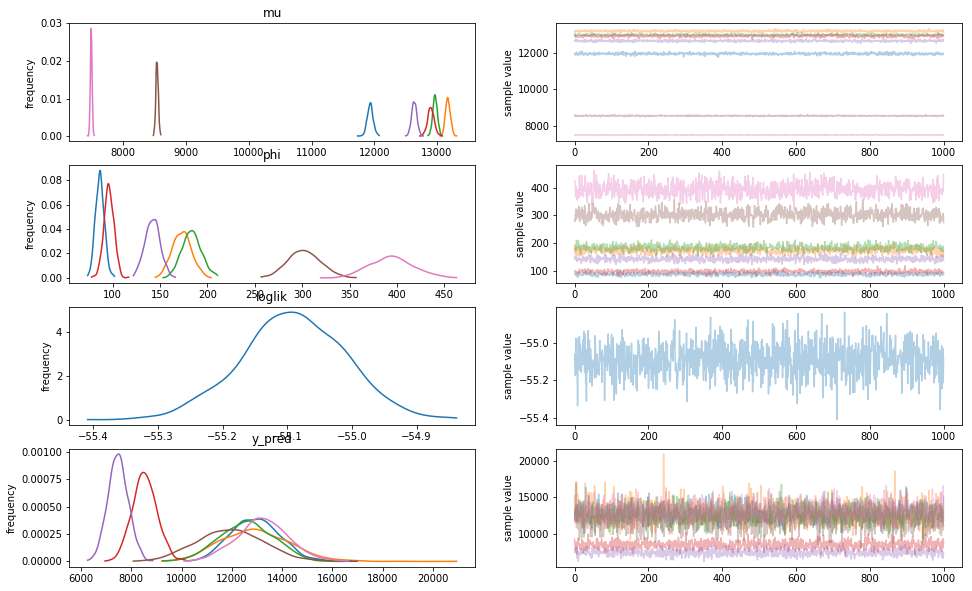

In [21]:
fit.plot();

In [25]:
def separate_negbin_data_extractor(data):
    prior_stds = weekday_priors_by_year_2000()['std'].values
    prior_mu = weekday_priors_by_year_2000()['mean'].values
    prior_phi = (prior_mu ** 2) / (prior_stds ** 2 - prior_mu)
    return dict(
        prior_mu=prior_mu,
        prior_stds=prior_stds,
        prior_phi=prior_phi,
        V_mu=4,
        V_phi=0.5,
        x_train=data['x_train'],
        x_test=data['x_test'],
        y_train=data['y_train'],
        y_test=data['y_test'],
        T=7,
        N=len(data['x_train']))

In [22]:
def fit_stan_model_on_sliding_windows(iterations, stan_data_extractor, persist_path, stan_model, num_windows):
    if not os.path.exists(persist_path):
        os.mkdir(persist_path)
    all_prediction_errors = []
    for i in range(num_windows):
        data = get_train_and_test_for_sliding_window(datetime(2014, 1, 1) + timedelta(days=i * 7))
        fit = stan_model.sampling(seed=COMMON_SEED, data=stan_data_extractor(data), iter=iterations, chains=1,
                                 control=dict(adapt_delta=0.99, max_treedepth=20))
        print(fit)
        check_convergence(fit, also_print=True)
        pred_err = fit.extract()['y_pred'].mean(axis=0) - data['y_test']
        all_prediction_errors.append(pred_err)
        with gzip.open(os.path.join(persist_path, 'fit%d_summary.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.summary(), f)
        with gzip.open(os.path.join(persist_path, 'fit%d_extract.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit.extract(), f)         
        with gzip.open(os.path.join(persist_path, 'fit%d_pred_err.pkl.gz' % i), 'wb') as f:
            pickle.dump(pred_err, f)
        with gzip.open(os.path.join(persist_path, 'fit%d_y_test.pkl.gz' % i), 'wb') as f:
            pickle.dump(data['y_test'], f)
        with gzip.open(os.path.join(persist_path, 'fit%d.pkl.gz' % i), 'wb') as f:
            pickle.dump(fit, f)                        
    return rmse(np.concatenate(all_prediction_errors))

In [31]:
# Quick check: one time window.
%%time

fit_stan_model_on_sliding_windows(
    500,
    separate_negbin_data_extractor,
    'fit_separate_negbin', 
    model_separate_weekdays,
    1)

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.83  44.71  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.44  38.62  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.21  34.94  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.24  51.19  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4     2.4  37.95  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8539.1    1.32  20.82 8503.3 8523.4 8540.5 8552.0 8584.0    250    1.0
mu[6]     7488.7    1.12  17.65 7455.4 7476.8 7488.2 7500.2 7524.7    250    1.0
phi[0]     85.17    0.26   4.07  76.84  82.56  85.31  87.77  93.55    250    1.0
phi[1]    171.68    0.72   9.44  152.4 166.46 172.04 178.36 190.91    171    1.0
phi[2

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


CPU times: user 1min 47s, sys: 157 ms, total: 1min 47s
Wall time: 1min 47s


2029.024440665584

In [33]:
%%time

# All time windows.
fit_stan_model_on_sliding_windows(
    500,
    separate_negbin_data_extractor,
    'fit_separate_negbin', 
    model_separate_weekdays,
    52)

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.83  44.71  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.44  38.62  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.21  34.94  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.24  51.19  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4     2.4  37.95  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8539.1    1.32  20.82 8503.3 8523.4 8540.5 8552.0 8584.0    250    1.0
mu[6]     7488.7    1.12  17.65 7455.4 7476.8 7488.2 7500.2 7524.7    250    1.0
phi[0]     85.17    0.26   4.07  76.84  82.56  85.31  87.77  93.55    250    1.0
phi[1]    171.68    0.72   9.44  152.4 166.46 172.04 178.36 190.91    171    1.0
phi[2

/home/inonpe/jupyter/dtu_bda_project/env/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.


Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.37   53.3  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.55  40.33  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.12  33.55  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.09  48.86  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.31  36.47  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8538.0    1.29  20.44 8495.4 8524.9 8539.0 8552.0 8576.2    250    1.0
mu[6]     7488.3     1.0  13.92 7460.0 7479.8 7488.6 7498.7 7514.7    194    1.0
phi[0]     86.51    0.36   5.21  75.44  82.55  86.73  90.27  95.36    205   1.02
phi[1]    173.19    0.73  10.12 154.52 166.55 173.52 179.86 191.78    191    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.15  49.77  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.35  37.21  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.13  33.74  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.25  51.37  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.65  41.92  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8535.8    1.35  21.42 8492.6 8522.2 8536.4 8548.9 8577.0    250    1.0
mu[6]     7482.7    1.06  16.81 7451.2 7472.2 7482.5 7494.5 7513.8    250    1.0
phi[0]     86.78     0.4   4.96  77.98  83.02  86.85  89.96  96.52    152   1.01
phi[1]     173.0    0.63  10.02 155.41 165.35  173.1 179.44 195.37    250    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.17   50.1  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.46  38.88  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.31  36.46  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.13   49.5  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.36  37.32  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8532.9    1.23  19.53 8493.5 8519.9 8533.0 8546.9 8572.9    250    1.0
mu[6]     7480.5    0.94   14.8 7449.3 7472.6 7480.5 7489.9 7509.5    250    1.0
phi[0]     86.35    0.29   4.29  78.96  83.19  85.84  88.82  95.97    213    1.0
phi[1]     172.1    0.74   8.96 154.77 165.69 171.86 178.82 189.54    145    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.46  54.65  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4     2.3  36.39  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.62  41.39  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.45   54.5  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.84  44.83  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8527.7    1.21  19.16 8489.9 8514.6 8528.1 8540.1 8565.0    250    1.0
mu[6]     7477.7    0.93  14.46 7446.6 7468.6 7478.8 7488.8 7505.9    240    1.0
phi[0]     86.71    0.37   4.91  77.24  83.19  86.69  90.02  96.04    179    1.0
phi[1]    171.95     0.6   8.66 155.56 166.31 171.72 178.04 189.65    208    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.93  46.34  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.85  45.14  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
mu[2]      1.3e4    2.27  35.87  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.14  49.65  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.24  35.42  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8522.1    1.36  21.51 8481.0 8508.0 8522.6 8535.1 8570.6    250    1.0
mu[6]     7476.7    0.83  13.05 7452.7 7467.7 7477.2 7486.1 7502.4    250    1.0
phi[0]     86.83    0.38    5.1  77.41  83.23  86.72  90.42  96.14    181    1.0
phi[1]    171.31    0.59   9.27 153.04 165.51  171.2 177.72 188.51    250    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.49  47.93  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    189    1.0
mu[1]      1.3e4    2.39   37.8  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.19  34.68  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    4.34  52.06  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    144    1.0
mu[4]      1.3e4    2.75  43.54  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8520.6    1.32  20.88 8480.1 8506.7 8520.4 8536.4 8560.6    250    1.0
mu[6]     7473.3    0.98  15.55 7444.3 7462.3 7473.9 7484.5 7502.4    250    1.0
phi[0]     85.18    0.44   4.49  77.02   81.9  84.96  88.28  94.13    103    1.0
phi[1]     170.8    0.66  10.38 147.32 163.89  170.6 177.39  194.1    250    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.25  51.39  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.75  43.41  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.22  35.16  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.26  51.55  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.59  41.01  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8517.5    1.25  19.83 8479.5 8505.0 8518.7 8530.0 8555.5    250    1.0
mu[6]     7470.3    1.04   16.4 7439.4 7459.2 7469.8 7481.2 7500.3    250   1.02
phi[0]     85.98    0.32   4.07  77.62  83.18   86.1  88.91  93.52    165   1.01
phi[1]    171.41    0.74   9.86 153.18  165.2 171.73 178.02 193.29    178   1.01
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.17  50.16  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.53  39.92  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4     2.5   39.6  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.15  49.81  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.58  40.75  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8510.9    1.35  21.39 8469.1 8496.5 8510.3 8523.0 8556.0    250    1.0
mu[6]     7467.4    0.91  14.45 7438.2 7457.3 7467.6 7478.4 7492.3    250    1.0
phi[0]     86.48    0.49   5.33  76.09   82.7  86.61  89.65  97.97    118    1.0
phi[1]    170.69    0.75   9.11 152.98 164.45 170.87 176.11  188.7    148   1.01
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.45  54.51  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4     2.6  41.03  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.01
mu[2]      1.3e4    2.65  41.86  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.18  50.35  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[4]      1.3e4    2.57  40.68  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8508.8    1.11  17.58 8473.7 8495.6 8509.5 8521.0 8545.0    250    1.0
mu[6]     7465.5    0.85  13.48 7439.0 7456.1 7465.3 7475.4 7489.6    250    1.0
phi[0]     87.05    0.42   5.05  76.81  83.99  87.03   90.1   97.8    142   1.01
phi[1]    168.96    1.42  10.16 145.43 163.38  170.1 175.34 187.88     51    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.42  48.91  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    204   1.01
mu[1]      1.3e4    2.61  41.22  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.59  40.95  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.83  51.37  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    180    1.0
mu[4]      1.3e4    2.35  37.15  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8506.1    1.25  19.76 8465.2 8493.8 8505.6 8519.6 8545.6    250    1.0
mu[6]     7464.2    0.97  15.39 7435.6 7454.1 7463.2 7475.1 7494.2    250    1.0
phi[0]     86.02    0.37   4.72  77.77  82.23  85.89  89.18  94.83    166    1.0
phi[1]    170.69    0.94   9.93 153.61 163.09 170.28 176.51 190.49    112   1.01
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.93  53.48  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    185   1.01
mu[1]      1.3e4    2.47  39.09  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250   1.03
mu[2]      1.3e4    2.53  40.01  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.54  45.21  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    163    1.0
mu[4]      1.3e4    2.81  39.97  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    203    1.0
mu[5]     8503.4    1.14  18.08 8469.2 8490.4 8503.4 8515.3 8539.2    250    1.0
mu[6]     7462.2    0.95  15.02 7433.3 7452.0 7462.1 7471.7 7491.1    250    1.0
phi[0]     86.56    0.44   4.72  76.98  83.44  86.56  89.18  96.31    115    1.0
phi[1]    170.78    0.55   8.72 155.44 164.83 170.76 176.36 189.78    250    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    2.89  45.77  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    250    1.0
mu[1]      1.3e4    2.65  41.84  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.25  35.51  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    3.69  52.87  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    205    1.0
mu[4]      1.3e4    2.72  43.05  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8501.4     1.2  19.05 8465.7 8486.8 8501.2 8515.5 8539.0    250    1.0
mu[6]     7461.5    0.91  14.33 7431.9 7452.6 7462.0 7471.2 7489.6    250    1.0
phi[0]     86.64    0.39   4.85   77.4  83.44  86.63  89.73  95.69    151   1.01
phi[1]    170.69    0.57   8.95 152.83 164.45 170.55 176.82 188.63    250    1.0
phi[2

Inference for Stan model: anon_model_424ae25909336bda8789dc6180cfae2a.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]      1.2e4    3.49  49.66  1.2e4  1.2e4  1.2e4  1.2e4  1.2e4    203    1.0
mu[1]      1.3e4    2.69  42.51  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[2]      1.3e4    2.23  35.23  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[3]      1.3e4    4.11  58.57  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    203   1.01
mu[4]      1.3e4    2.73  43.11  1.3e4  1.3e4  1.3e4  1.3e4  1.3e4    250    1.0
mu[5]     8501.9    1.26  19.92 8463.5 8489.2 8500.6 8514.5 8543.6    250    1.0
mu[6]     7460.3    0.92  14.51 7430.7 7450.9 7460.3 7470.6 7490.6    250    1.0
phi[0]     86.53     0.4   4.73  77.42  83.06  86.38  90.44  95.08    143    1.0
phi[1]    171.46    0.62   9.82 151.78  165.2  171.0 177.92 191.67    250    1.0
phi[2

893.2366867904584

In [55]:
pickle.load(gzip.open(os.path.join('fit_separate_negbin', 'fit9_extract.pkl.gz'), 'rb'))['loglik'].mean()

-56.718042746407214

In [59]:
def performance_stats_from_pickled(dirname):
    prediction_errors = np.concatenate(list(pickle.load(gzip.open(f, 'rb')) 
        for f in glob.glob(os.path.join(dirname, 'fit*_pred_err.pkl.gz'))))
    loglik_avgs = list(pickle.load(gzip.open(f, 'rb'))['loglik'].mean() 
        for f in glob.glob(os.path.join(dirname, 'fit*_extract.pkl.gz')))
    pickle.load(gzip.open(os.path.join('fit_separate_negbin', 'fit9_extract.pkl.gz'), 'rb'))['loglik'].mean()
    return {
        'rmse': rmse(prediction_errors),
        'loglik': sum(loglik_avgs)
    }

performance_stats_from_pickled('fit_separate_negbin')

{'loglik': -2947.561747783959, 'rmse': 893.2366867904585}